In [37]:
import os
import pickle
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.spatial import Delaunay
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import networkx as nx
from itertools import combinations
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [38]:
# =====================================================
#                   Utility Functions
# =====================================================

def load_data(filepath: str) -> dict:
    """
    Load data from pickle file. The data is expected to be a dictionary:
    {node_identifier: pd.DataFrame with 'traffic_flow', 'Xkoordinat', 'Ykoordinat'}
    """
    with open(filepath, "rb") as f:
        data = pickle.load(f)
    return data


def split_dataframes(df_dict: dict, train_ratio=0.7, val_ratio=0.1):
    """
    Splits the dictionary of DataFrames into train, validation, and test sets.
    Splits are done by time sequence.

    Args:
        df_dict: {node_key: pd.DataFrame}
        train_ratio: fraction of data for training
        val_ratio: fraction of data for validation

    Returns:
        df_dict_train, df_dict_val, df_dict_test
    """
    df_dict_train, df_dict_val, df_dict_test = {}, {}, {}
    for key, df in df_dict.items():
        n = len(df)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))
        df_train = df.iloc[:train_end].copy()
        df_val = df.iloc[train_end:val_end].copy()
        df_test = df.iloc[val_end:].copy()

        df_dict_train[key] = df_train
        df_dict_val[key] = df_val
        df_dict_test[key] = df_test

    return df_dict_train, df_dict_val, df_dict_test


def create_sliding_window_data(df_dict: dict, lookback: int, pred_horizon: int):
    """
    Create sliding windows for each node.
    Returns {node: X_node}, {node: y_node}
    X_node shape: (#samples, lookback), y_node shape: (#samples, pred_horizon)
    """
    X_dict, y_dict = {}, {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node, y_node = [], []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i+lookback])
            y_node.append(node_series[i+lookback:i+lookback+pred_horizon])
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict


def combine_node_data(X_dict: dict, y_dict: dict):
    """
    Combine data from all nodes into single arrays.
    """
    X_list = [X_dict[node] for node in X_dict]
    y_list = [y_dict[node] for node in y_dict]
    X_combined = np.concatenate(X_list, axis=0)
    y_combined = np.concatenate(y_list, axis=0)
    return X_combined, y_combined

In [51]:
def clean_graph(graph: nx.Graph) -> nx.Graph:
    """
    Clean the graph: remove self-loops, duplicate edges, keep largest component.
    """
    g = graph.copy()
    g.remove_edges_from(list(nx.selfloop_edges(g)))

    if len(g.nodes) > 0:
        largest_component = max(nx.connected_components(g), key=len)
        g = g.subgraph(largest_component).copy()

    return g

# =====================================================
#                   Graph Construction
# =====================================================

def create_distance_graph(df_dict, weighted=False, degree=4):
    """
    Create a graph where edges are based on spatial proximity.
    """
    graph = nx.Graph()
    coords = {}
    for key, df in df_dict.items():
        x, y = df['Xkoordinat'].iloc[0], df['Ykoordinat'].iloc[0]
        graph.add_node(key, x=x, y=y, traffic_flow=df['traffic_flow'].values)
        coords[key] = (x, y)

    # Compute all pairwise distances
    keys = list(df_dict.keys())
    dist_list = []
    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            x1, y1 = coords[k1]
            x2, y2 = coords[k2]
            dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            dist_list.append((k1, k2, dist))

    # Sort edges by distance (ascending)
    dist_list.sort(key=lambda x: x[2])

    # Add edges while respecting degree constraints
    for k1, k2, dist in dist_list:
        if graph.degree[k1] < degree and graph.degree[k2] < degree:
            if weighted:
                # Normalize weights if desired
                graph.add_edge(k1, k2, weight=1/(1+dist))
            else:
                graph.add_edge(k1, k2)


    graph = clean_graph(graph)
    return graph


def create_delaunay_graph(df_dict):
    """
    Create a graph based on the Delaunay triangulation of spatial coordinates.

    Parameters:
        df_dict (dict): A dictionary where keys are node identifiers and values are
                        pandas DataFrames containing 'Xkoordinat' and 'Ykoordinat'.

    Returns:
        nx.Graph: A Delaunay graph where edges are formed from Delaunay triangulation.
    """
    # Initialize an empty graph
    graph = nx.Graph()

    # Extract node coordinates and their identifiers
    nodes = []
    coords = []
    for key, df in df_dict.items():
        x, y = df['Xkoordinat'].iloc[0], df['Ykoordinat'].iloc[0]
        graph.add_node(key, x=x, y=y, traffic_flow=df['traffic_flow'].values)
        nodes.append(key)
        coords.append((x, y))

    # Perform Delaunay triangulation
    tri = Delaunay(coords)

    # Add edges from the Delaunay triangulation
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                node1 = nodes[simplex[i]]
                node2 = nodes[simplex[j]]
                graph.add_edge(node1, node2)

    # Clean the graph (remove self-loops, keep largest connected component, etc.)
    graph = clean_graph(graph)

    return graph

def create_correlation_graph(df_dict_train, df_dict_full, threshold=0.5, weighted=False, degree=6):
    """
    Create a correlation-based graph using training data for correlation calculation.
    """
    graph = nx.Graph()
    keys = list(df_dict_full.keys())
    for key, df in df_dict_full.items():
        graph.add_node(key, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    # Compute correlation
    corr_matrix = {}
    for i, k1 in enumerate(keys):
        for j, k2 in enumerate(keys[i+1:], i+1):
            corr = np.corrcoef(df_dict_train[k1]['traffic_flow'], df_dict_train[k2]['traffic_flow'])[0, 1]
            corr_matrix[(k1, k2)] = corr
            corr_matrix[(k2, k1)] = corr

    # Sort edges by correlation
    for k1 in keys:
        potential = [(k2, corr_matrix[(k1, k2)]) for k2 in keys if k1 != k2 and (k1, k2) in corr_matrix]
        potential.sort(key=lambda x: -x[1])  # descending order by correlation
        for k2, c in potential:
            if graph.degree[k1] < degree and graph.degree[k2] < degree and c > threshold:
                if weighted:
                    graph.add_edge(k1, k2, weight=c)
                else:
                    graph.add_edge(k1, k2)
    
    # Find any node without any edges, then connect it to the node with the hgihest correlation
    for k in keys:
        if graph.degree[k] == 0:
            corr = [(k2, corr_matrix[(k, k2)]) for k2 in keys if k != k2 and (k, k2) in corr_matrix]
            corr.sort(key=lambda x: -x[1])
            graph.add_edge(k, corr[0][0], weight=corr[0][1])

    
    # find any nodes that are not connected to any other nodes, and connect
    graph = clean_graph(graph)
    return graph


def create_cosine_graph(df_dict, weighted=False, degree=4, threshold = 0.5):
    """
    Create a graph based on cosine similarity between full node time series.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    features = [df_dict[k]['traffic_flow'].values for k in keys]
    features = np.array(features)  # shape: (#nodes, #timesteps)
    # Compute cosine similarity
    norm = np.linalg.norm(features, axis=1, keepdims=True)
    normed = features / (norm + 1e-8)
    sim_matrix = normed @ normed.T  # cosine similarity

    for i, k1 in enumerate(keys):
        graph.add_node(k1,
                       x=df_dict[k1]['Xkoordinat'].iloc[0],
                       y=df_dict[k1]['Ykoordinat'].iloc[0],
                       traffic_flow=df_dict[k1]['traffic_flow'].values)

    # Sort by similarity
    for i, k1 in enumerate(keys):
        potential = [(keys[j], sim_matrix[i, j]) for j in range(len(keys)) if i != j]
        potential.sort(key=lambda x: -x[1])
        for k2, sim_val in potential:
            if graph.degree[k1] < degree and graph.degree[k2] < degree and sim_val > 0.5:
                if weighted:
                    graph.add_edge(k1, k2, weight=sim_val)
                else:
                    graph.add_edge(k1, k2)

    # Find any node without any edges, then connect it to the node with the hgihest similarity
    for k in keys:
        if graph.degree[k] == 0:
            sim = [(keys[j], sim_matrix[i, j]) for j in range(len(keys)) if i != j]
            sim.sort(key=lambda x: -x[1])
            graph.add_edge(k, sim[0][0], weight=sim[0][1])
    
    graph = clean_graph(graph)
    return graph


def create_fully_connected_graph(df_dict, weighted=False):
    """
    Create a fully connected graph. Optionally assign random weights.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    for k in keys:
        df = df_dict[k]
        graph.add_node(k, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            if weighted:
                graph.add_edge(k1, k2, weight=np.random.rand())
            else:
                graph.add_edge(k1, k2)
    graph = clean_graph(graph)
    return graph


def create_dynamic_weight_graph(df_dict, lookback, pred_horizon, adaptive_factor=1.0, max_degree=4):
    """
    Create a graph with dynamic weights based on correlation of sliding windows.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    for k in keys:
        df = df_dict[k]
        graph.add_node(k, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    # Precompute sliding windows
    sliding_windows = {
        k: np.lib.stride_tricks.sliding_window_view(df_dict[k]['traffic_flow'].values, lookback)[:-pred_horizon]
        for k in keys
    }

    # Compute avg correlation over time for each pair
    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            w1 = sliding_windows[k1]
            w2 = sliding_windows[k2]
            # correlation per window
            corrs = []
            for t in range(min(len(w1), len(w2))):
                if np.std(w1[t]) > 0 and np.std(w2[t]) > 0:
                    c = np.corrcoef(w1[t], w2[t])[0, 1]
                    corrs.append(c)
            if len(corrs) > 0:
                avg_weight = np.mean(corrs)
                threshold = adaptive_factor * avg_weight
                if avg_weight > threshold:
                    graph.add_edge(k1, k2, weight=avg_weight)

    # Enforce max degree
    for node in list(graph.nodes()):
        edges = sorted(graph.edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)
        if len(edges) > max_degree:
            for edge in edges[max_degree:]:
                graph.remove_edge(edge[0], edge[1])

    graph = clean_graph(graph)
    return graph


def TOTAL_RANDOM_WEIGHTS(df_dict, degrees=32):
    # Initialize a graph
    num_nodes = len(df_dict)
    graph = nx.Graph()

    # Add nodes with attributes
    for i, (key, df) in enumerate(df_dict.items()):
        graph.add_node(i, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0], traffic_flow=df['traffic_flow'].values)

    # Randomly add edges while respecting degree constraints
    nodes = list(graph.nodes)
    max_attempts = num_nodes * degrees * 10  # Safety limit to prevent infinite loops
    attempts = 0

    while any(graph.degree(n) < degrees for n in nodes):
        u, v = np.random.choice(nodes, size=2, replace=False)
        # Add an edge only if it doesn't exist and both nodes are under degree limit
        if not graph.has_edge(u, v) and graph.degree(u) < degrees and graph.degree(v) < degrees:
            graph.add_edge(u, v, weight=np.random.rand())
        
        attempts += 1
        if attempts >= max_attempts:
            print("Warning: Maximum attempts reached, stopping early.")
            break

    # Return the graph and edge weights
    return graph, nx.get_edge_attributes(graph, 'weight')

def connect_nodes_with_erdos_renyi(df_dict, p=0.5, seed=42, weighted=False):
    np.random.seed(seed)
    num_nodes = len(df_dict)

    er_graph = nx.Graph()


    for i, (key, df) in enumerate(df_dict.items()):
        er_graph.add_node(i, 
                          x=df['Xkoordinat'].iloc[0], 
                          y=df['Ykoordinat'].iloc[0], 
                          traffic_flow=df['traffic_flow'].values)

    for u in er_graph.nodes:
        for v in er_graph.nodes:
            if u < v and np.random.rand() < p:
                if weighted:
                    er_graph.add_edge(u, v, weight=np.random.rand())
                else:
                    er_graph.add_edge(u, v)
    # Get edge weights
    edge_weights = nx.get_edge_attributes(er_graph, 'weight')

    return er_graph, edge_weights

In [40]:
# =====================================================
#                   Model Definition
# =====================================================

class TrafficGCN(nn.Module):
    """
    A GCN-based model for predicting future traffic flow.
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, data: Data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = self.fc(x)
        return x


# =====================================================
#                   Metrics
# =====================================================

def mape_loss(y_true, y_pred):
    """
    Mean Absolute Percentage Error.
    """
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def vape_loss(y_true, y_pred):
    """
    Variance Absolute Percentage Error = 
    (var(|y_true - y_pred|) / var(y_true)) * 100
    """
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    diff = np.abs(y_true - y_pred)
    var_diff = np.var(diff)
    var_true = np.var(y_true)
    if var_true == 0:
        return 0.0
    return (var_diff / var_true) * 100

def rmse_loss(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))


class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()
    
    def forward(self, y_pred, y_true):
        epsilon = 1e-7  # Small value to avoid division by zero
        return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [41]:
# =====================================================
#                   Training & Evaluation
# =====================================================
def train_model(model, train_data, val_data, epochs, lr, device="cuda:0"):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=50, cooldown=0, min_lr=1e-6)

    best_val_loss = float('inf')
    best_state = None
    early_stopping_patience = 200
    no_improve = 0

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data)
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_out = model(val_data)
            val_loss = criterion(val_out, val_data.y)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Step the scheduler based on validation loss
        scheduler.step(val_loss.item())

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        if no_improve > early_stopping_patience:
            # Early stopping triggered
            break
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Best Val Loss: {best_val_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    return train_losses, val_losses


def evaluate_model(model, test_data):
    """
    Evaluate the model on test data using MAPE, VAPE, and RMSE.
    """
    model.eval()
    with torch.no_grad():
        pred = model(test_data)

    mape = mape_loss(test_data.y, pred)
    vape = vape_loss(test_data.y, pred)
    rmse = rmse_loss(test_data.y, pred)
    return mape, vape, rmse, pred.cpu().numpy(), test_data.y.cpu().numpy()


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# =====================================================
#                   General Decoder
# =====================================================
class GeneralMLPDecoder(nn.Module):
    """
    General Decoder for reconstructing node features.
    """
    def __init__(self, latent_dim, hidden_dim, out_dim):
        super(GeneralMLPDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, out_dim)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class GeneralGraphAutoEncoder(nn.Module):
    """
    General Autoencoder for Graph Data: Encodes node features to latent space
    and decodes them to reconstruct the original features.
    """
    def __init__(self, in_channels, hidden_channels, latent_channels):
        super(GeneralGraphAutoEncoder, self).__init__()
        # Encoder: GCN layers
        self.encoder1 = GCNConv(in_channels, hidden_channels)
        self.encoder2 = GCNConv(hidden_channels, latent_channels)
        self.dropout = nn.Dropout(p=0.3)
        # Decoder: MLP for node-level reconstruction
        self.decoder = GeneralMLPDecoder(latent_channels, hidden_channels, in_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Encoder
        x = F.relu(self.encoder1(x, edge_index))
        x = self.dropout(x)
        z = F.normalize(self.encoder2(x, edge_index), p=2, dim=1)  # Latent space embeddings
        # Decoder
        recon_features = self.decoder(z)  # Reconstruct node features
        return z, recon_features

class TrafficPredictor(nn.Module):
    """
    Traffic prediction model using node embeddings and temporal features.
    """
    def __init__(self, embedding_dim, temporal_dim, hidden_dim, output_dim):
        super(TrafficPredictor, self).__init__()
        self.fc1 = nn.Linear(embedding_dim + temporal_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, combined_features):
        x = F.relu(self.fc1(combined_features))
        x = self.dropout(x)
        return self.fc2(x)


In [43]:
# =====================================================
#                   Main Execution
# =====================================================

# Hyperparameters
DATA_PATH = "data_prep/one_year.pkl"  # Adjust your path
TRAIN_RATIO = 0.5
VAL_RATIO = 0.3
LOOKBACK = 50
PRED_HORIZON = 1
HIDDEN_CHANNELS = 64
LR = 1e-3
EPOCHS = 5000
DEGREE = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and split data
final_dataframes = load_data(DATA_PATH)
df_dict_train, df_dict_val, df_dict_test = split_dataframes(final_dataframes, TRAIN_RATIO, VAL_RATIO)

# Create sliding window data
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, LOOKBACK, PRED_HORIZON)
X_val_dict, y_val_dict = create_sliding_window_data(df_dict_val, LOOKBACK, PRED_HORIZON)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, LOOKBACK, PRED_HORIZON)

node_lengths = {node: X_train_dict[node].shape[0] for node in X_train_dict}

# Combine data
X_train, y_train = combine_node_data(X_train_dict, y_train_dict)
X_val, y_val = combine_node_data(X_val_dict, y_val_dict)
X_test, y_test = combine_node_data(X_test_dict, y_test_dict)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float, device=device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float, device=device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float, device=device)

In [44]:
def evaluate_model(model, embeddings, temporal_features, targets):
    """
    Evaluate the traffic flow predictor on test data.
    """
    model.eval()
    with torch.no_grad():
        combined_features = torch.cat([embeddings, temporal_features], dim=1)
        preds = model(combined_features)
        mse = mean_squared_error(targets.cpu(), preds.cpu())
        mae = mean_absolute_error(targets.cpu(), preds.cpu())
    return mse, mae, preds


In [45]:
# Normalize features
scaler = StandardScaler()
X_train_normalized = torch.tensor(
    scaler.fit_transform(X_train), dtype=torch.float, device=device
)
X_val_normalized = torch.tensor(
    scaler.transform(X_val), dtype=torch.float, device=device
)
X_test_normalized = torch.tensor(
    scaler.transform(X_test), dtype=torch.float, device=device
)

In [59]:
graph_models = {
    "Distance_Weighted": lambda: create_distance_graph(final_dataframes, weighted=True, degree=DEGREE),
    "Correlation_Weighted": lambda: create_correlation_graph(df_dict_train, final_dataframes, threshold=0.5, weighted=True, degree=DEGREE),
    "Cosine_Weighted": lambda: create_cosine_graph(df_dict_train, weighted=True, degree=DEGREE),
    #"Fully_Connected_Weighted": lambda: create_fully_connected_graph(final_dataframes, weighted=True),
    "Erdos_Renyi_Weighted": lambda: connect_nodes_with_erdos_renyi(final_dataframes, p=0.5),
    "Random_Weighted": lambda: TOTAL_RANDOM_WEIGHTS(final_dataframes, degrees=DEGREE)[0],
    # Unweighted graphs
    "Distance_Unweighted": lambda: create_distance_graph(final_dataframes, weighted=False, degree=DEGREE),
    "Delaunay_unweighted": lambda: create_delaunay_graph(final_dataframes),
    "Correlation_Unweighted": lambda: create_correlation_graph(df_dict_train, final_dataframes, threshold=0.5, weighted=False, degree=DEGREE),
    "Cosine_Unweighted": lambda: create_cosine_graph(df_dict_train, weighted=False, degree=DEGREE),
    "Fully_Connected_Unweighted": lambda: create_fully_connected_graph(final_dataframes, weighted=False),
    "Erdos_Renyi_Unweighted": lambda: connect_nodes_with_erdos_renyi(final_dataframes, p=0.5),
    "Random_Unweighted": lambda: nx.random_geometric_graph(len(final_dataframes), 0.1)
}

results = {}

# Load pre-trained GAE
gae_model = GeneralGraphAutoEncoder(in_channels=LOOKBACK, hidden_channels=64, latent_channels=32)
gae_model.load_state_dict(torch.load("model.pth", map_location=device))
gae_model.to(device)
gae_model.eval()

early_stopping_patience = 200
best_val_loss = float('inf')

for model_name, graph_fn in graph_models.items():
    print(f"Processing graph: {model_name}")

    # Create the graph
    graph = graph_fn()
    node_mapping = {node: i for i, node in enumerate(graph.nodes())}
    edge_index = torch.tensor(
        [[node_mapping[u], node_mapping[v]] for u, v in graph.edges()],
        dtype=torch.long, device=device
    ).t().contiguous()

    gae_model.eval()
    with torch.no_grad():
        train_embeddings, _ = gae_model(Data(x=X_train_normalized, edge_index=edge_index, num_nodes=len(graph.nodes)))
        val_embeddings, _ = gae_model(Data(x=X_val_normalized, edge_index=edge_index, num_nodes=len(graph.nodes)))
        test_embeddings, _ = gae_model(Data(x=X_test_normalized, edge_index=edge_index, num_nodes=len(graph.nodes)))

    # Prepare graph data
    graph_data = Data(x=X_train_normalized, edge_index=edge_index, num_nodes=len(graph.nodes))

    # Step 1: Extract embeddings using GAE
    with torch.no_grad():
        embeddings, _ = gae_model(graph_data)

    # Repeat embeddings to match temporal features
    embedding_repeated_train = embeddings.repeat_interleave(X_train_normalized.size(0) // embeddings.size(0), dim=0)
    embedding_repeated_val = embeddings.repeat_interleave(X_val_normalized.size(0) // embeddings.size(0), dim=0)
    embedding_repeated_test = embeddings.repeat_interleave(X_test_normalized.size(0) // embeddings.size(0), dim=0)

    # Step 2: Train traffic predictor
    predictor = TrafficPredictor(
        embedding_dim=32, 
        temporal_dim=50, 
        hidden_dim=64, 
        output_dim=1
    ).to(device)

    train_losses = []
    val_losses = []

    def train_with_logging(model, embeddings, temporal_features, targets, val_embeddings, val_features, val_targets, epochs, lr, device):
        model.to(device)
        best_val_loss = float('inf')
        optimizer = Adam(model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=50, cooldown=0, min_lr=1e-6)
        criterion = nn.MSELoss()
        val_criterion = nn.MSELoss()

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            combined_features = torch.cat([embeddings, temporal_features], dim=1)
            preds = model(combined_features)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            # Validation
            model.eval()
            with torch.no_grad():
                val_combined_features = torch.cat([val_embeddings, val_features], dim=1)
                val_preds = model(val_combined_features)
                val_loss = val_criterion(val_preds, val_targets)
                val_losses.append(val_loss.item())
            
            scheduler.step(val_loss.item())

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_state = model.state_dict()
                no_improve = 0
            else:
                no_improve += 1

            if no_improve > early_stopping_patience:
                # Early stopping triggered
                break

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f} VAPE Loss: {vape_loss(val_targets, val_preds):.4f} MAPE Loss: {mape_loss(val_targets, val_preds):.4f} Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        return model

    predictor = train_with_logging(
        predictor,
        train_embeddings,
        X_train_normalized,
        y_train_tensor,
        val_embeddings,
        X_val_normalized,
        y_val_tensor,
        epochs=5000,
        lr=1e-3,
        device=device,
    )

    # Step 3: Evaluate the predictor
    mse, mae, preds = evaluate_model(predictor, test_embeddings, X_test_normalized, y_test_tensor)

    # Additional Metrics
    preds_np = preds.cpu().numpy()
    actuals_np = y_test_tensor.cpu().numpy()

    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actuals_np - preds_np) / np.clip(actuals_np, a_min=1e-10, a_max=None))) * 100
    vape = (np.var(np.abs(actuals_np - preds_np)) / np.var(actuals_np)) * 100

    # Last x predictions
    x = 1000
    last_x_preds = preds_np[-x:]
    last_x_actuals = actuals_np[-x:]

    # Store results
    results[model_name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_mse": mse,
        "test_rmse": rmse,
        "test_mae": mae,
        "test_mape": mape,
        "test_vape": vape,
        "last_x_predictions": last_x_preds.tolist(),
        "last_x_actuals": last_x_actuals.tolist(),
        "epoch_count": len(train_losses),
    }

# Print summary
print("======================== SUMMARY ========================")
for model_name, res in results.items():
    print(
        f"Graph: {model_name}, "
        f"Test RMSE: {res['test_rmse']:.4f}, "
        f"Test MSE: {res['test_mse']:.4f}, "
        f"Test MAE: {res['test_mae']:.4f}, "
        f"Test MAPE: {res['test_mape']:.4f}%, "
        f"Test VAPE: {res['test_vape']:.4f}%"
    )

# Save results to a file
with open("graph_results.pkl", "wb") as f:
    pickle.dump(results, f)


C:\Users\gonde\AppData\Local\Temp\ipykernel_19220\2675546451.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gae_model.load_state_dict(torch.load("model.pth", map_locat

Processing graph: Distance_Weighted
Epoch 0, Train Loss: 34624.9375, Val Loss: 39055.8906 VAPE Loss: 100.0189 MAPE Loss: 102.7676 Learning Rate: 0.001000
Epoch 10, Train Loss: 34387.6055, Val Loss: 38776.7383 VAPE Loss: 99.3667 MAPE Loss: 101.5092 Learning Rate: 0.001000
Epoch 20, Train Loss: 34129.8750, Val Loss: 38467.1797 VAPE Loss: 98.6621 MAPE Loss: 99.1468 Learning Rate: 0.001000
Epoch 30, Train Loss: 33806.1914, Val Loss: 38073.3047 VAPE Loss: 97.7409 MAPE Loss: 96.5920 Learning Rate: 0.001000
Epoch 40, Train Loss: 33390.2305, Val Loss: 37569.8164 VAPE Loss: 96.5562 MAPE Loss: 93.8276 Learning Rate: 0.001000
Epoch 50, Train Loss: 32874.2969, Val Loss: 36946.8516 VAPE Loss: 95.0823 MAPE Loss: 90.9480 Learning Rate: 0.001000
Epoch 60, Train Loss: 32255.3672, Val Loss: 36199.3711 VAPE Loss: 93.2941 MAPE Loss: 88.2611 Learning Rate: 0.001000
Epoch 70, Train Loss: 31529.9688, Val Loss: 35329.3594 VAPE Loss: 91.1813 MAPE Loss: 85.7931 Learning Rate: 0.001000
Epoch 80, Train Loss: 3070

KeyboardInterrupt: 

In [ ]:
# Optionally save results to a file
with open("model_results_one_year_with_autoencoder.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
# print("Last 10 predictions vs Actuals:")
# for p, a in zip(last_100_preds, last_100_actuals):
#     print(f"Pred: {p[0]:.2f}  Actual: {a[0]:.2f}")

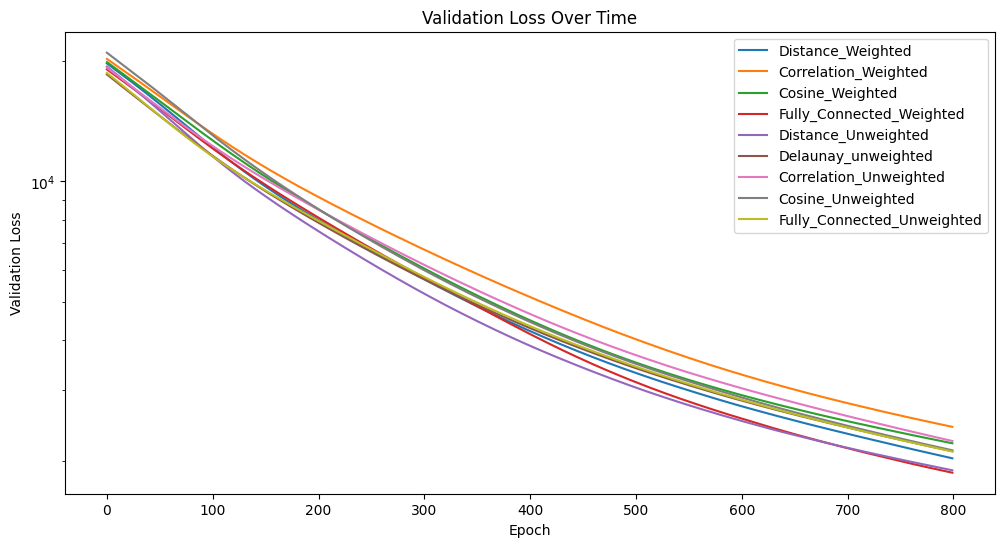

In [ ]:
# Plot the validation loss over time for all models in the same plot
plt.figure(figsize=(12, 6))
for model_name, res in results.items():
    plt.plot(res['val_losses'][200:], label=model_name)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.yscale("log")
plt.title("Validation Loss Over Time")
plt.legend()
plt.show()

C:\Users\gonde\AppData\Local\Temp\ipykernel_17776\1845202796.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(model_names, rotation=45, ha='right')
C:\Users\gonde\AppData\Local\Temp\ipykernel_17776\1845202796.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(model_names, rotation=45, ha='right')


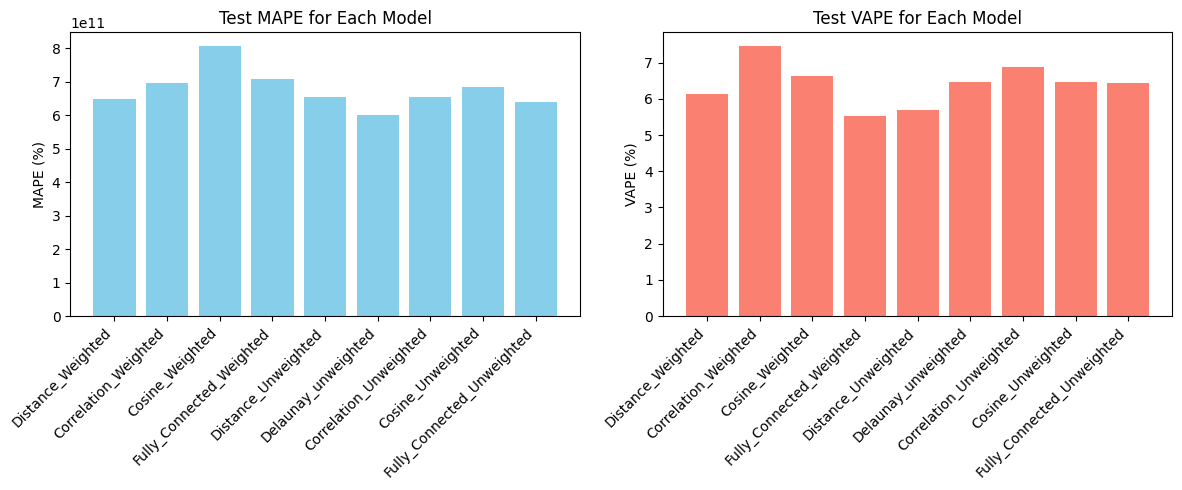

Summary Table:
                     Model     MAPE (%)  VAPE (%)      RMSE         R2  Epoch Count
         Distance_Weighted 6.500205e+11  6.147658 45.045200 -28.659686         1000
      Correlation_Weighted 6.979476e+11  7.464758 50.043842 -27.408796         1000
           Cosine_Weighted 8.078436e+11  6.637039 47.337212 -38.696482         1000
  Fully_Connected_Weighted 7.072648e+11  5.538112 43.200146 -28.981162         1000
       Distance_Unweighted 6.544246e+11  5.680704 43.477432 -24.576425         1000
       Delaunay_unweighted 6.003684e+11  6.458985 46.073631 -24.062574         1000
    Correlation_Unweighted 6.544269e+11  6.873344 47.808243 -28.793004         1000
         Cosine_Unweighted 6.837680e+11  6.470438 46.301670 -29.813675         1000
Fully_Connected_Unweighted 6.406173e+11  6.429172 46.207977 -28.496956         1000


In [ ]:
from sklearn.metrics import r2_score

# 1. Plot MAPE and VAPE values for each model
model_names = list(results.keys())
mapes = [results[m]['test_mape'] for m in model_names]
vapes = [results[m]['test_vape'] for m in model_names]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(model_names, mapes, color='skyblue')
ax[0].set_title('Test MAPE for Each Model')

ax[0].set_xticklabels(model_names, rotation=45, ha='right')
ax[0].set_ylabel('MAPE (%)')

ax[1].bar(model_names, vapes, color='salmon')
ax[1].set_title('Test VAPE for Each Model')
ax[1].set_xticklabels(model_names, rotation=45, ha='right')
ax[1].set_ylabel('VAPE (%)')


plt.tight_layout()
plt.show()

# R2
# 3. Plot Actual vs. Predicted for a selected model and compute R²
selected_model = "Distance_Weighted"  # change to any model you want
preds = results[selected_model]["last_x_predictions"]
actuals = results[selected_model]["last_x_actuals"]

# Compute R²
r2 = r2_score(actuals, preds)

# 2. Create a table summarizing MAPE, VAPE, RMSE, and Epoch Count
data_for_table = {
    "Model": model_names,
    "MAPE (%)": mapes,
    "VAPE (%)": vapes,
    "RMSE": [results[m]['test_rmse'] for m in model_names],
    "R2": [r2_score(results[m]['last_x_actuals'], results[m]['last_x_predictions']) for m in model_names],
    "Epoch Count": [results[m]['epoch_count'] for m in model_names]

}
df = pd.DataFrame(data_for_table)
print("Summary Table:")
print(df.to_string(index=False))




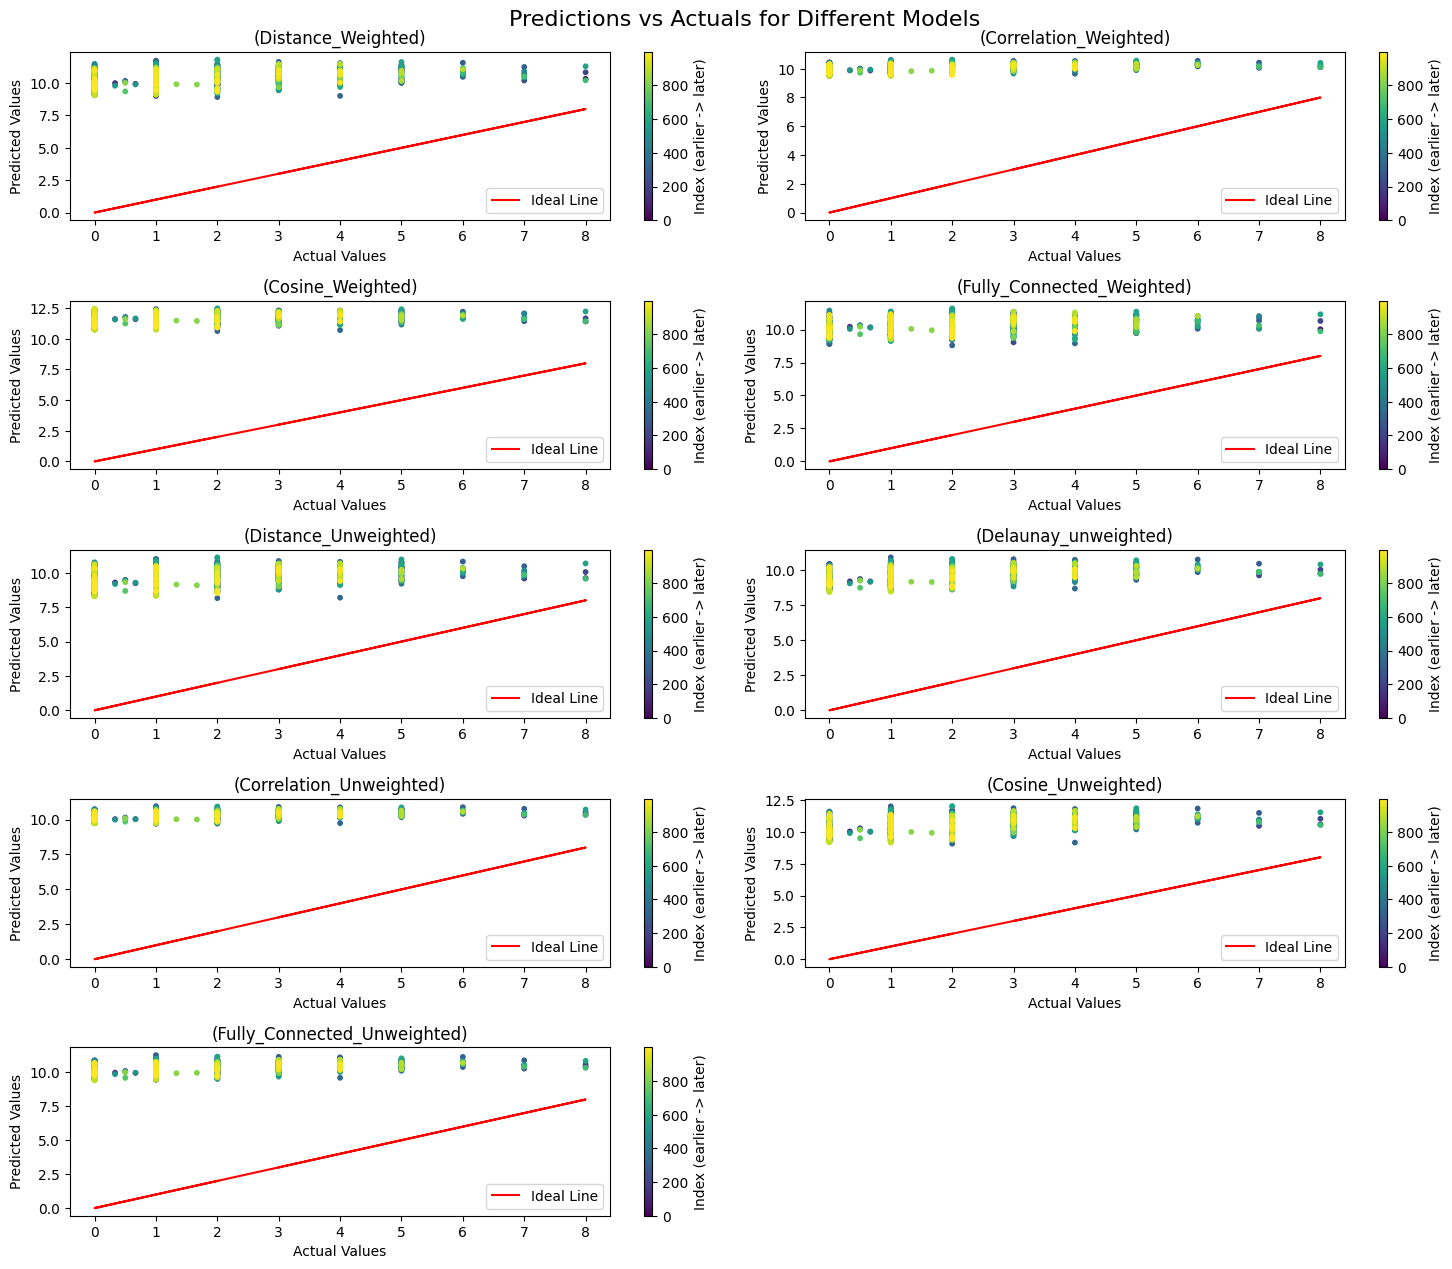

In [ ]:
# loop over all models and Plott the evolution of predictions vs actual over time, in subplots
plt.figure(figsize=(15, 15))
for i, model_name in enumerate(results.keys()):
    actuals = results[model_name]["last_x_actuals"]
    preds = results[model_name]["last_x_predictions"]
    # set a main title over all subplots
    plt.suptitle("Predictions vs Actuals for Different Models", fontsize=16)

    plt.subplot(6, 2, i+1)
    plt.scatter(actuals, preds, c=np.arange(len(preds)), cmap='viridis', s=10)
    plt.plot(actuals, actuals, color='red', label='Ideal Line')
    plt.colorbar(label='Index (earlier -> later)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'({model_name})')
    plt.legend()
plt.tight_layout()
plt.show()

### Analyze prediction horizon and Lookback

In [ ]:
import itertools
import pandas as pd
from sklearn.metrics import r2_score

# Define ranges for lookback periods and prediction horizons
lookback_periods = [5, 10, 20, 50]  # adjust as needed
prediction_horizons = [1, 2,  4, 20, 60]  # adjust as needed

graph_models = {
    #"Distance_Weighted": lambda: create_distance_graph(final_dataframes, weighted=True, degree=DEGREE),
    "Correlation_Weighted": lambda: create_correlation_graph(df_dict_train, final_dataframes, threshold=0.5, weighted=True, degree=DEGREE),
    #"Cosine_Weighted": lambda: create_cosine_graph(df_dict_train, weighted=True, degree=DEGREE),
    #"Fully_Connected_Weighted": lambda: create_fully_connected_graph(final_dataframes, weighted=True),
    #"Distance_Unweighted": lambda: create_distance_graph(final_dataframes, weighted=False, degree=DEGREE),
    "Correlation_Unweighted": lambda: create_correlation_graph(df_dict_train, final_dataframes, threshold=0.5, weighted=False, degree=DEGREE),
    #"Cosine_Unweighted": lambda: create_cosine_graph(df_dict_train, weighted=False, degree=DEGREE),
    #"Fully_Connected_Unweighted": lambda: create_fully_connected_graph(final_dataframes, weighted=False),
}

results = []

# Iterate through combinations of lookback periods and prediction horizons
for lookback, pred_horizon in itertools.product(lookback_periods, prediction_horizons):
    print(f"=== Testing Lookback: {lookback}, Prediction Horizon: {pred_horizon} ===")

    # Create sliding window data for train, val, and test sets
    X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
    X_val_dict, y_val_dict = create_sliding_window_data(df_dict_val, lookback, pred_horizon)
    X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)

    # Combine data
    X_train, y_train = combine_node_data(X_train_dict, y_train_dict)
    X_val, y_val = combine_node_data(X_val_dict, y_val_dict)
    X_test, y_test = combine_node_data(X_test_dict, y_test_dict)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float, device=device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float, device=device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float, device=device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float, device=device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float, device=device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float, device=device)

    # Train and evaluate each graph model
    for model_name, graph_fn in graph_models.items():
        graph = graph_fn()

        # If graph has no edges or nodes, skip
        if graph.number_of_nodes() == 0:
            print(f"{model_name}: Graph is empty, skipping.")
            continue

        node_mapping = {node: i for i, node in enumerate(graph.nodes())}
        edge_index = torch.tensor(
            [[node_mapping[u], node_mapping[v]] for u, v in graph.edges()],
            dtype=torch.long, device=device
        ).t().contiguous()

        train_data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor.view(-1, pred_horizon))
        val_data = Data(x=X_val_tensor, edge_index=edge_index, y=y_val_tensor.view(-1, pred_horizon))
        test_data = Data(x=X_test_tensor, edge_index=edge_index, y=y_test_tensor.view(-1, pred_horizon))

        # Initialize model
        hc = HIDDEN_CHANNELS  # or a fixed number like 32
        model = TrafficGCN(in_channels=lookback, hidden_channels=hc, out_channels=pred_horizon).to(device)

        # Train model
        train_losses, val_losses = train_model(model, train_data, val_data, EPOCHS, LR, device=device)

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_out = model(test_data)
            criterion = torch.nn.MSELoss()
            test_loss = criterion(test_out, test_data.y)
            test_rmse = torch.sqrt(test_loss).item()
            test_mae = torch.mean(torch.abs(test_out - test_data.y)).item()

            # Compute additional metrics
            mape = mape_loss(test_data.y, test_out)
            vape = vape_loss(test_data.y, test_out)
            r2 = r2_score(test_data.y.cpu().numpy(), test_out.cpu().numpy())

        # Print minimal info for this combination
        print(f"Model: {model_name}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MSE: {criterion}, MAPE: {mape:.4f}%, VAPE: {vape:.4f}%, R²: {r2:.4f}")

        # Store results
        results.append({
            "Lookback": lookback,
            "Prediction_Horizon": pred_horizon,
            "Model": model_name,
            "Test RMSE": test_rmse,
            "Test MAE": test_mae,
            "MAPE (%)": mape,
            "VAPE (%)": vape,
            "R2": r2,
            "Epoch Count": len(train_losses)
        })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("===== Summary of All Results =====")
print(results_df.to_string(index=False))


=== Testing Lookback: 5, Prediction Horizon: 1 ===
Epoch 0, Train Loss: 28946.8613, Val Loss: 30877.4824, Best Val Loss: 30877.4824, Learning Rate: 0.001000
Model: Correlation_Weighted, RMSE: 161.0544, MAE: 69.2574, MAPE: 87.5682%, VAPE: 79.3144%, R²: 0.0269
Epoch 0, Train Loss: 39556.6953, Val Loss: 42891.7539, Best Val Loss: 42891.7539, Learning Rate: 0.001000
Model: Correlation_Unweighted, RMSE: 189.4961, MAE: 81.8519, MAPE: 105.2550%, VAPE: 109.5783%, R²: -0.3471
=== Testing Lookback: 5, Prediction Horizon: 2 ===
Epoch 0, Train Loss: 35040.3906, Val Loss: 39159.2930, Best Val Loss: 39159.2930, Learning Rate: 0.001000
Model: Correlation_Weighted, RMSE: 181.1737, MAE: 78.1756, MAPE: 97.4864%, VAPE: 100.2020%, R²: -0.2305
Epoch 0, Train Loss: 36202.2773, Val Loss: 39673.0977, Best Val Loss: 39673.0977, Learning Rate: 0.001000
Model: Correlation_Unweighted, RMSE: 182.4372, MAE: 78.6693, MAPE: 100.9001%, VAPE: 101.6350%, R²: -0.2477
=== Testing Lookback: 5, Prediction Horizon: 4 ===
Epo